Download dataset from: https://drive.google.com/uc?id=1-WZKE5xHw-3m_SL_PtOgwkzdFROIWqih

In [1]:
import pandas as pd

pd.set_option("max_colwidth", 800)

raw_df = pd.read_csv("data.csv")
raw_df = raw_df[raw_df["Score"] > 0]
df = raw_df[:10000]

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df["Text"], df["Score"], test_size=0.2)

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer

# VOCAB_SIZE is the number of unique words we want to use for the Tokenizer.
VOCAB_SIZE = 10000

# The Tokenizer class is used to vectorize the text data.
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(X_train) # This step creates the word index.

X_train_enc = tokenizer.texts_to_sequences(X_train)
X_test_enc = tokenizer.texts_to_sequences(X_test)

Mean Length: 76.94125
Standard Deviation: 74.01642418029596


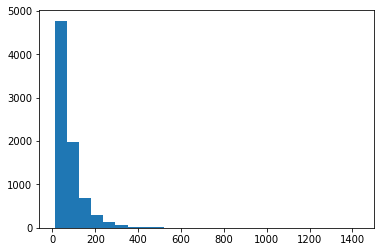

In [4]:
import numpy as np
import matplotlib.pyplot as plt

reviewLenghts = [len(x) for x in X_train_enc]
mean = np.mean(reviewLenghts)
std = np.std(reviewLenghts)
print("Mean Length:", mean)
print("Standard Deviation:", std)

_ = plt.hist(reviewLenghts, bins=25)

As seen from the graph above, all documents don't have the same number of tokens. To make the number of tokens same, we pad the vectors with zeros to `MAX_LEN` size and also truncate any document having more than `MAX_LEN` tokens to length of `MAX_LEN`

In [5]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_LEN = np.ceil(mean + 2 * std).astype(int)

X_train_enc = pad_sequences(X_train_enc, maxlen=MAX_LEN , padding="post")
X_test_enc = pad_sequences(X_test_enc, maxlen=MAX_LEN, padding="post")

The output of a neural network doesn't give us the number of stars the review got. Instead it gives a probability distribution of the stars. The correct prediction is the one with the highest probability.<br>
Hence, we'll transform our discrete data of 1-5 star rating into a vector of classes representing the probabilty that the rating is n-stars. Since our data is dicrete, the vector of classes is binary (either 1 or 0).<br>
`to_categorical` converts a class vector (integers from 0 to nb_classes-1) to binary class matrix.<br>
It converts classes to an array of 0s and 1 where only the correct category is a 1 and the rest are 0s.

In [6]:
from tensorflow.keras.utils import to_categorical

y_train_enc = to_categorical(y_train)
y_test_enc = to_categorical(y_test)

for i in range(5):
    print(y_train.iloc[i], y_train_enc[i])

5 [0. 0. 0. 0. 0. 1.]
4 [0. 0. 0. 0. 1. 0.]
3 [0. 0. 0. 1. 0. 0.]
5 [0. 0. 0. 0. 0. 1.]
5 [0. 0. 0. 0. 0. 1.]


## Word Embedding
![](https://pbs.twimg.com/media/DKWbi9nXoAAd_un.jpg)<br>
Word embeddings are a class of techniques where individual words are represented as real-valued vectors in a predefined vector space. This allows words that are used in similar ways to result in having similar representations, naturally capturing their meaning.<br>
In the given picture, 


In the given picture, 4 words `King`, `Queen`, `Man`, `Woman` are represented as vectors in a 2-dimensional vector space. Here `EMBEDDING_DIMENSION = 2`. The vectors can be related as `King` - `Man` + `Woman` = `Queen`.

## Creating the Neural Network
1. The `Sequential` model is a linear stack of layers of neurons.
2. The `Embedding` layer  enables us to convert each word into a fixed length vector of defined size which is used in word embedding.
3. The `Conv1D` (Convolution 1D) layer creates a convolution kernel that is convolved with the layer input over a single spatial (or temporal) dimension to produce a tensor of outputs. This enables the model to take the context in which the word is used into account.
4. The `GlobalMaxPool1D` (Global Max Pooling 1D) layer is used to reduce the dimensionality of the feature maps output by the `Conv1D` layer. The `GlobalMaxPool1D` takes a 2-dimensional tensor of size `input_size x input_channels` and computes the maximum of all the `input_size` values for each of the `input_channels`.
5. The `Dense` layer is simple layer of neurons in which each neuron receives input from all the neurons of previous layer, thus called as dense.
6. The `Dropout` layer randomly sets input units to 0 with a frequency of `rate` at each step during training time, which helps prevent overfitting.

## Activation Functions
1. Rectified Linear Units, or ReLU, are a type of activation function that are linear in the positive dimension, but zero in the negative dimension. <br>
`R(z) = max(0, z)`<br>
![](https://miro.medium.com/max/357/1*oePAhrm74RNnNEolprmTaQ.png)
2. The Softmax activation function calculates the relative probabilities. It uses all values in the `Dense` layer and it is used as the activation function of the output layer. <br>
![](https://www.gstatic.com/education/formulas2/443397389/en/softmax_function.svg)

In [7]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, GlobalMaxPool1D, Conv1D

EMBEDDING_DIMENSION = 50

model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIMENSION, input_length=MAX_LEN))
model.add(Conv1D(50, 4, 1, activation='relu'))
model.add(GlobalMaxPool1D())
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 225, 50)           500000    
                                                                 
 conv1d (Conv1D)             (None, 222, 50)           10050     
                                                                 
 global_max_pooling1d (Globa  (None, 50)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 6)                 306       
                                                                 
Total params: 510,356
Trainable params: 510,356
Non-trainable params: 0
_________________________________________________________________


In [8]:
history = model.fit(
    X_train_enc,
    y_train_enc,
    epochs=30,
    batch_size=64,
    validation_split=0.1,
)

Epoch 1/30
113/113 [==============================] - 7s 37ms/step - loss: 1.3183 - accuracy: 0.6057 - val_loss: 1.1353 - val_accuracy: 0.6338
Epoch 2/30
113/113 [==============================] - 3s 22ms/step - loss: 1.0801 - accuracy: 0.6160 - val_loss: 1.0169 - val_accuracy: 0.6363
Epoch 3/30
113/113 [==============================] - 2s 22ms/step - loss: 0.9449 - accuracy: 0.6485 - val_loss: 0.9396 - val_accuracy: 0.6587
Epoch 4/30
113/113 [==============================] - 3s 23ms/step - loss: 0.8090 - accuracy: 0.7068 - val_loss: 0.8819 - val_accuracy: 0.6888
Epoch 5/30
113/113 [==============================] - 2s 22ms/step - loss: 0.6617 - accuracy: 0.7696 - val_loss: 0.8508 - val_accuracy: 0.6975
Epoch 6/30
113/113 [==============================] - 2s 22ms/step - loss: 0.5176 - accuracy: 0.8381 - val_loss: 0.8464 - val_accuracy: 0.7013
Epoch 7/30
113/113 [==============================] - 3s 22ms/step - loss: 0.3839 - accuracy: 0.9058 - val_loss: 0.8658 - val_accuracy: 0.7025

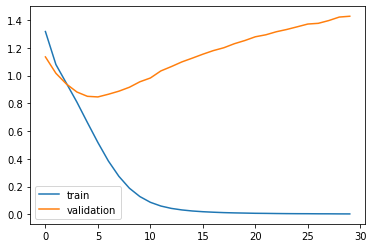

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'validation'])
plt.show()

## Overfitting
From the above graph, we can see that after 6-8 epochs, the model starts performing worse on the validation sets even though it performs great with almost 100% accuracy in the training sets. This is called overfitting. Overfitting occurs when the model fits exactly against it training data. When this happens, it cannot perform accurately with unseen data, defeating its purpose.<br>
Overfitting can be prevented by adding a `Dropout` layer or by running the trainig for fewer epochs.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(raw_df['Text'], raw_df['Score'])
VOCAB_SIZE = 10000

tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)

X_train_enc = tokenizer.texts_to_sequences(X_train)
X_test_enc = tokenizer.texts_to_sequences(X_test)

X_train_enc = pad_sequences(X_train_enc, maxlen=MAX_LEN, padding="post")
X_test_enc = pad_sequences(X_test_enc, maxlen=MAX_LEN, padding="post")

np.mean([len(t) for t in X_train_enc])

y_train_enc = to_categorical(y_train)
y_test_enc = to_categorical(y_test)

In [20]:
from tensorflow.keras.layers import Dropout

EMBEDDING_DIMENSION = 50

model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIMENSION, input_length=MAX_LEN))
model.add(Conv1D(50, 4, 1, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(GlobalMaxPool1D())
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 225, 50)           500000    
                                                                 
 conv1d_2 (Conv1D)           (None, 222, 50)           10050     
                                                                 
 dropout_1 (Dropout)         (None, 222, 50)           0         
                                                                 
 global_max_pooling1d_2 (Glo  (None, 50)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 6)                 306       
                                                                 
Total params: 510,356
Trainable params: 510,356
Non-trainable params: 0
________________________________________________

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint

mc = ModelCheckpoint('minLossModel.h5', monitor='val_loss', mode='min', save_best_only=True)

history = model.fit(
    X_train_enc,
    y_train_enc,
    epochs=10,
    batch_size=4096,
    validation_split=0.1,
    callbacks = [mc]
)

Epoch 1/10
94/94 [==============================] - 216s 2s/step - loss: 1.1602 - accuracy: 0.6370 - val_loss: 1.1001 - val_accuracy: 0.6594
Epoch 2/10
94/94 [==============================] - 145s 2s/step - loss: 0.8264 - accuracy: 0.6956 - val_loss: 0.8855 - val_accuracy: 0.7203
Epoch 3/10
94/94 [==============================] - 145s 2s/step - loss: 0.7302 - accuracy: 0.7273 - val_loss: 0.8324 - val_accuracy: 0.7388
Epoch 4/10
94/94 [==============================] - 145s 2s/step - loss: 0.6874 - accuracy: 0.7428 - val_loss: 0.7925 - val_accuracy: 0.7498
Epoch 5/10
94/94 [==============================] - 145s 2s/step - loss: 0.6594 - accuracy: 0.7536 - val_loss: 0.7646 - val_accuracy: 0.7562
Epoch 6/10
94/94 [==============================] - 144s 2s/step - loss: 0.6368 - accuracy: 0.7623 - val_loss: 0.7489 - val_accuracy: 0.7650
Epoch 7/10
94/94 [==============================] - 130s 1s/step - loss: 0.6186 - accuracy: 0.7691 - val_loss: 0.7340 - val_accuracy: 0.7695
Epoch 8/10
94

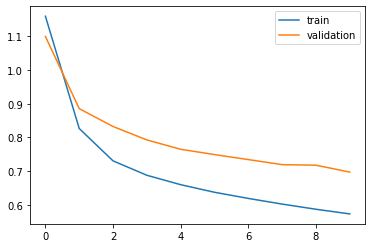

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'validation'])
plt.show()

In [24]:
loss, acc = model.evaluate(X_test_enc, y_test_enc)
print("Loss:", round(loss, 5))
print("Accuracy:", round(acc, 5))

4442/4442 [==============================] - 32s 7ms/step - loss: 0.7000 - accuracy: 0.7762
Loss: 0.69997
Accuracy: 0.77621


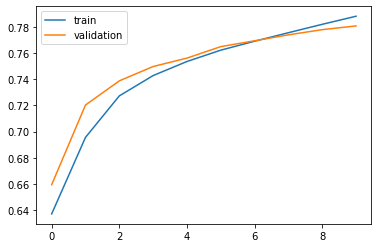

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'validation'])
plt.show()

By training the model with the full dataset, adding a `Dropout` layer and running fewer epochs, overfitting has been prevented. This can be seen from the graphs. The validation set loss is decreasing and the accuracy is increasing, meaning the model is learning and not becoming worse. 